In [28]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms, models
# import timm
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn as nn
%matplotlib inline

torch.cuda.empty_cache()

In [29]:
import wandb #ne logam la platforma
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Verificam device-ul

In [30]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    if torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

device = get_device()

print(f'Using device: {device}')

Using device: cuda


Start Configure the Network

In [31]:
configurations = {
    1: { 
        'dataset': 'Brain Tumor Segmentation',
        'model' : 'UNet',
        'batch_size' : 64,
        'num_epochs' : 50,
        'learning_rate' : 0.001,
        'optimizer' : 'Adam',
        'scheduler' : 'StepLR',
        'hidden_size' : 128,
        'n_channels': 1,
        'n_classes': 1,
        'bilinear': True 
    }
}

In [32]:
selected_config = None
model = None
while selected_config is None:
    try:
        config_number = int(input("Enter a number 1 - 6 for each config type: "))
        if config_number in configurations:
            selected_config = configurations[config_number]
            print(f"Selected Configuration: {selected_config}")
        else:
            print("Invalid input. Please enter a number between 1 and 6.")
    except ValueError:
        print("Please enter a valid number.")

wandb.init(project="pytorch_training_pipeline", config=selected_config)
config = wandb.config

Selected Configuration: {'dataset': 'Brain Tumor Segmentation', 'model': 'UNet', 'batch_size': 64, 'num_epochs': 50, 'learning_rate': 0.001, 'optimizer': 'Adam', 'scheduler': 'StepLR', 'hidden_size': 128, 'n_channels': 1, 'n_classes': 1, 'bilinear': True}


accuracy,▁▁▁▁▁
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
accuracy,0.01352
epoch,5
loss,0.69319


Data Augumentation

In [40]:
from torchvision import transforms



image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)  # Normalize mask to [0, 1]
])
display_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convertim grayscale la RGB
    transforms.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),  # Inversăm normalizarea
    transforms.ToPILImage()  # Convertim tensorul în imagine PIL
])

train_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
])

Construct the data loader

Train Images batch shape: torch.Size([4, 1, 128, 128])
Train Masks batch shape: torch.Size([4, 1, 128, 128])


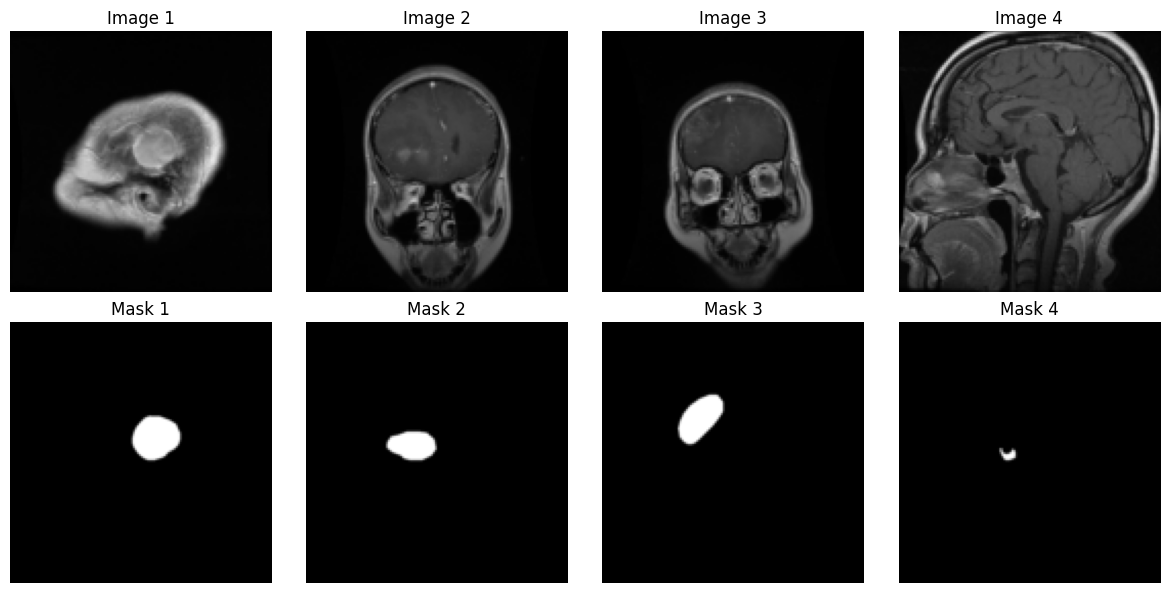

In [ ]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

def combined_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice

def compute_iou(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    return (intersection / (union + 1e-6)).item()

class CachedDataSet(Dataset):
    def __init__(self, image_files, mask_files, image_transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        mask_path = self.mask_files[index]
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

def get_train_test_split(image_dir, mask_dir, test_size=0.3, random_seed=42):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    
    train_images, test_images, train_masks, test_masks = train_test_split(
        image_files, mask_files, test_size=test_size, random_state=random_seed
    )
    
    return train_images, test_images, train_masks, test_masks

# Directorii pentru imagini și măști
image_dir = './Brain Tumor Segmentation/images'
mask_dir = './Brain Tumor Segmentation/masks'

# Împărțirea seturilor de date
train_images, test_images, train_masks, test_masks = get_train_test_split(image_dir, mask_dir)

# Crearea dataset-urilor și DataLoader-elor
train_dataset = CachedDataSet(train_images, train_masks, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = CachedDataSet(test_images, test_masks, image_transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Afișarea imaginilor și măștilor din loader-ul de antrenament
for images, masks in train_loader:
    print(f"Train Images batch shape: {images.shape}")
    print(f"Train Masks batch shape: {masks.shape}")
    
    # Afișăm primele 4 imagini și măști
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    for i in range(4):
        # Afișăm imaginea
        ax = axes[0, i]
        img = display_transform(images[i])  # Inversăm transformarea și convertim în PIL
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Image {i+1}")
        
        # Afișăm masca
        ax = axes[1, i]
        mask = masks[i].squeeze().cpu().numpy()  # Convertim tensorul în numpy array
        ax.imshow(mask, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Mask {i+1}")
    
    plt.tight_layout()
    plt.show()
    break

Modelul U Net.

In [35]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.enc_conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_relu1 = nn.ReLU(inplace=True)
        self.enc_pool1 = nn.MaxPool2d(2)
        
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_relu2 = nn.ReLU(inplace=True)
        self.enc_pool2 = nn.MaxPool2d(2)
        
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        self.enc_relu3 = nn.ReLU(inplace=True)
        self.enc_pool3 = nn.MaxPool2d(2)
        
        self.bottleneck_conv = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(512)
        self.bottleneck_relu = nn.ReLU(inplace=True)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(256)
        self.dec_relu3 = nn.ReLU(inplace=True)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.dec_relu2 = nn.ReLU(inplace=True)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_relu1 = nn.ReLU(inplace=True)
        
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        enc1 = self.enc_relu1(self.enc_bn1(self.enc_conv1(x)))
        enc1_pool = self.enc_pool1(enc1)
        
        enc2 = self.enc_relu2(self.enc_bn2(self.enc_conv2(enc1_pool)))
        enc2_pool = self.enc_pool2(enc2)
        
        enc3 = self.enc_relu3(self.enc_bn3(self.enc_conv3(enc2_pool)))
        enc3_pool = self.enc_pool3(enc3)
        
        bottleneck = self.bottleneck_relu(self.bottleneck_bn(self.bottleneck_conv(enc3_pool)))
        
        dec3_up = self.upconv3(bottleneck)
        # Ajustează dimensiunile dacă este necesar
        if dec3_up.shape != enc3.shape:
            enc3 = F.interpolate(enc3, size=dec3_up.shape[2:], mode="bilinear", align_corners=False)
        dec3 = self.dec_relu3(self.dec_bn3(self.dec_conv3(torch.cat([dec3_up, enc3], dim=1))))
        
        dec2_up = self.upconv2(dec3)
        if dec2_up.shape != enc2.shape:
            enc2 = F.interpolate(enc2, size=dec2_up.shape[2:], mode="bilinear", align_corners=False)
        dec2 = self.dec_relu2(self.dec_bn2(self.dec_conv2(torch.cat([dec2_up, enc2], dim=1))))
        
        dec1_up = self.upconv1(dec2)
        if dec1_up.shape != enc1.shape:
            enc1 = F.interpolate(enc1, size=dec1_up.shape[2:], mode="bilinear", align_corners=False)
        dec1 = self.dec_relu1(self.dec_bn1(self.dec_conv1(torch.cat([dec1_up, enc1], dim=1))))
        
        out = self.final_activation(self.final_conv(dec1))
        
        return out

In [36]:
model = UNet(
        n_channels=config['n_channels'],
        n_classes=config['n_classes']
    ).to(device)

In [37]:
#optimizator configuration

if config.optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
elif config.optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)
elif config.optimizer == 'SGD_momentum':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
elif config.optimizer == 'SGD_nesterov':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, nesterov=True)
elif config.optimizer == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
elif config.optimizer == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=config.learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=0.1)

In [38]:
# config scheduler

# if config.scheduler == 'StepLR':
#     scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# elif config.scheduler == 'ReduceLROnPlateau':
#     scheduler = ReduceLROnPlateau(optimizer, 'min')
# else:
#     scheduler = None


Train

In [ ]:
#training loop : 
patience = 5
best_accuracy = 0.0
epochs_without_improvement = 0

criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(config.num_epochs):
    model.train()
    total_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    model.eval()
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            iou = compute_iou(outputs, masks)
            total_iou += iou
    
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(test_loader)
    
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")
    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "IoU": avg_iou})

    if avg_iou > best_accuracy:
        best_accuracy = avg_iou
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

{'epoch': 0, 'loss': 0.7129618152976036, 'accuracy': 0.013519486137058424}
{'epoch': 1, 'loss': 0.6937501469432418, 'accuracy': 0.013519486137058424}
{'epoch': 2, 'loss': 0.6933493143809375, 'accuracy': 0.013519486137058424}
{'epoch': 3, 'loss': 0.6932449477599628, 'accuracy': 0.013519486137058424}
{'epoch': 4, 'loss': 0.6932024656614261, 'accuracy': 0.013519486137058424}
Oprire timpurie activată la epoca 6
